In [45]:
!pip install numpy==1.23.5
!pip install torch==1.13.1+cu116 torchvision==0.14.1+cu116 torchaudio==0.13.1+cu116
!pip install diffusers==0.11.1
!pip install --ignore-installed Pillow==9.3.0
!pip install openai==0.26.4
!pip install SpeechRecognition==3.9.0
!pip install pygame==2.1.2
!pip install opencv-python==4.7.0.68
!pip install vosk==0.3.45
!pip install pydub==0.25.1
!pip install matplotlib==3.6.3
!pip install multiprocess==0.70.13
!pip install gradio==3.16.2
!pip install gtts==2.3.0
!pip install nltk==3.7
!pip install wave==0.0.2
!pip install transformers==4.25.1
!pip install keybert==0.7.0
!pip install rembg==2.0.30
!pip install accelerate
# PyAudio needs apt libraries first
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg
!pip install PyAudio==0.2.13
# nltk stuff
import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')

In [16]:
# Imports
import numpy as np
import openai
import requests
from transformers import pipeline
import torch
from string import punctuation
import speech_recognition as sr
from gtts import gTTS
import gradio as gr
import pygame
from pygame import mixer
import zipfile
import os
from IPython.display import Audio, display
from torch import autocast
from diffusers import StableDiffusionPipeline
import shutil
import os
import time
import threading

In [5]:
# Get github files
import os
import shutil
if os.path.exists("AI_Girlfriend_Reduced"):
    shutil.rmtree('./AI_Girlfriend_Reduced/')
!git clone https://github.com/gmongaras/AI_Girlfriend_Reduced.git

Cloning into 'AI_Girlfriend_Reduced'...
Updating files:  81% (107/131)
Updating files:  82% (108/131)
Updating files:  83% (109/131)
Updating files:  84% (111/131)
Updating files:  85% (112/131)
Updating files:  86% (113/131)
Updating files:  87% (114/131)
Updating files:  88% (116/131)
Updating files:  89% (117/131)
Updating files:  90% (118/131)
Updating files:  91% (120/131)
Updating files:  92% (121/131)
Updating files:  93% (122/131)
Updating files:  94% (124/131)
Updating files:  95% (125/131)
Updating files:  96% (126/131)
Updating files:  97% (128/131)
Updating files:  98% (129/131)
Updating files:  99% (130/131)
Updating files: 100% (131/131)
Updating files: 100% (131/131), done.
Filtering content:  40% (2/5)
Filtering content:  60% (3/5)
Filtering content:  80% (4/5)
Filtering content: 100% (5/5), 494.40 MiB | 553.54 MiB/s
Filtering content: 100% (5/5), 623.67 MiB | 29.65 MiB/s, done.


In [ ]:
# Move files from AI_Girlfriend to root
shutil.copytree("AI_Girlfriend_Reduced/", "./", dirs_exist_ok=True, ignore=shutil.ignore_patterns('.git', "Main.ipynb"))

In [2]:
# Import girlfriend and Img_Mover object
from Img_Mover.Img_Mover import Img_Mover
from Girlfriend_Obj import Girlfriend_Obj

# Speaking

In [11]:
# Open AI Key
# Can be optained using the following tutorial: https://medium.com/r/?url=https%3A%2F%2Felephas.app%2Fblog%2Fhow-to-create-openai-api-keys-cl5c4f21d281431po7k8fgyol0
openai.api_key = "[your key here]"

In [12]:
# Get the model
models = openai.Model

In [20]:
# Initial prompt with few-shot learning
initial_prompt = "The following is a conversation with me and my waifu girlfriend\n\n"\
        "Me: Hello\nGirlfriend: Hello\n"\
        "Me: How are you?\nGirlfriend: I am good\n"\
        "Me: I love you.\n"

In [19]:
# API request to GPT using the largest model - davinci-003
# https://beta.openai.com/docs/api-reference/introduction?lang=python
output = openai.Completion.create(
  model="text-davinci-003",
  prompt=initial_prompt,
  max_tokens=200,
  temperature=0.7
)["choices"][0]["text"]
output

"Girlfriend: I appreciate the sentiment, but I don't think we know each other well enough for that."

# GPT Alternative

In [28]:
# Load in the model
test_model = pipeline('text-generation',model="gmongaras/gpt-anime-sub-1.3B",
                      tokenizer="EleutherAI/gpt-neo-1.3B",
                      max_new_tokens=50,
                      torch_dtype=torch.float16,framework="pt",
                      device=torch.device("cuda:0"),
                      pad_token_id=50256)

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.36G [00:00<?, ?B/s]

In [16]:
# Used to get a response from the model
def get_response(input_text):
    return test_model(input_text)[0]["generated_text"][\
        len(input_text):].split("\n")[0].replace("Girlfriend: ", "")

In [28]:
get_response(initial_prompt)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'I do too'

# She Needs to Have a Memory

N/A

# We Need to Hear Each Other

In [31]:
# Used for STT
r = sr.Recognizer()

In [32]:
# Transcribes audio to text
def audio_to_text(audio):
    try:
        text = r.recognize_google(audio)
    except sr.UnknownValueError:
        text = "" # Default to nothing
            
    return text

In [33]:
# Used to get a response from the model
def get_response(input_text):
    return test_model(input_text)[0]["generated_text"][\
        len(input_text):].split("\n")[0].replace("Girlfriend: ", "").replace("Me: ", "").split(":")[0]

In [34]:
# Prompt that will be continuously updated
global prompt
prompt = "The following is a conversation with me and my waifu girlfriend\n\n"\
        "Me: Hello\nGirlfriend: Hello\n"\
        "Me: How are you?\nGirlfriend: I am good\n"

In [36]:
# Latest reponse variable
global cur_resp

# Initialize audio device
try:
    mixer.init()
except pygame.error:
    pass

# Handles audio input and returns a response
def handle_audio(audio_pth):
    global prompt
    global cur_resp
    # Get the audio if there is any
    if audio_pth:
        # Open the wav file and read in the data
        # Get the audio data
        audio = sr.AudioFile(audio_pth)
        with audio as source:
            audio = r.record(source)
        
        # Get the text from the audio
        text = audio_to_text(audio)
        
        # Add the text to the prompt so far
        prompt += f"Me: {text}\n"
        
        # Get a response
        resp = get_response(prompt)
        
        # Add the response to the prompt
        prompt += f"Girlfriend: {resp}\n"
        
        # Ensure audio is unloaded
        try:
            mixer.stop()
            mixer.music.unload()
        except pygame.error:
            pass
        
        # When the response is generated create a new audio file
        myobj = gTTS(text=resp, lang='en', slow=False)
        myobj.save("tmp.mp3")
        
        # Play the audio file
        try:
            mixer.music.load('tmp.mp3')
            mixer.music.play()
        except pygame.error:
            display(Audio("tmp.mp3", autoplay=True))
        
        cur_resp = resp
        return resp
    return cur_resp

In [37]:
audio_interface = gr.Blocks()
with audio_interface:
    audio_blk = gr.Audio(source="microphone", type="filepath", label="Response", live=True)
    text_blk = gr.Textbox(label="Reponse")
    audio_blk.change(handle_audio, inputs=[audio_blk], outputs=[text_blk])
    
audio_interface.launch(debug=True)

Keyboard interruption in main thread... closing server.


# I Should be Able to See Her

In [80]:
# Get the model
pipe = StableDiffusionPipeline.from_pretrained(
    'hakurei/waifu-diffusion',
    torch_dtype=torch.float16,
).to('cuda')
# Remove filter
#pipe.safety_checker = lambda images, clip_input: (images, False)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
# Create the image
settings = "1girl,solo focus,very wide shot,feamle focus,ratio:16:9,detailed,looking at viewer,facing viewer,facing forward,vtuber"
characteristics = "waifu,female,brown hair,blue eyes,sidelocks,slight blush,happy"
prompt = f"{settings} {characteristics}"
with autocast("cuda"):
    image = pipe(prompt, guidance_scale=10)["images"][0]

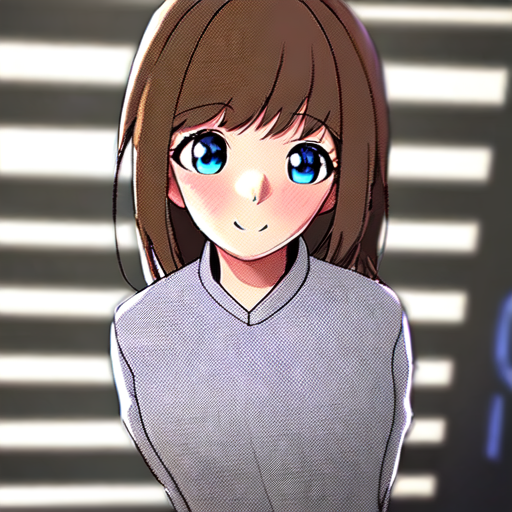

In [116]:
display(image)

In [ ]:
# If you want to take a look at the settings 
# (Note there is some pretty bad stuff on here. Not by doing, but it's the documentation :/)
# https://danbooru.donmai.us/wiki_pages/tag_group:image_composition

# I Want Her to Somewhat Move

In [10]:
# Let's initialize the object to allow the image to move
device = torch.device("cuda:0")
blink_time = 0.7
mover = Img_Mover(device, blink_time, "test3.png", automatic_EMA=True)

## Blinking Example

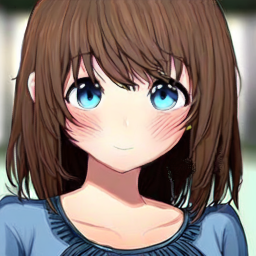

In [4]:
# Initial state
mover.pose[12] = mover.pose[13] = 0
mover.change_pose()

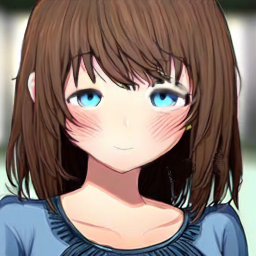

In [20]:
# 50% blink
mover.pose[12] = mover.pose[13] = 0.5
mover.change_pose()

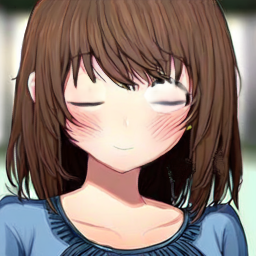

In [21]:
# 100% blink
mover.pose[12] = mover.pose[13] = 1
mover.change_pose()

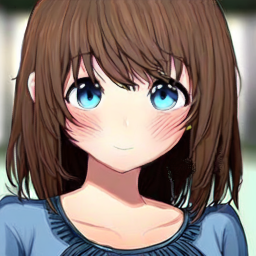

In [22]:
# Back to no blink
mover.pose[12] = mover.pose[13] = 0
mover.change_pose()

In [24]:
global cur_vec_update_cycle
cur_vec_update_cycle = [0, 0.25, 0.5, 0.75, 1, 0.75, 0.5, 0.25, 0]
global cur_vec_update_cycle_2
cur_vec_update_cycle_2 = [0, 0, 0.25, 0.5, 0.75, 0.5, 0.25, 0, 0]
global cur_vec_num_its
cur_vec_num_its = 100

# Show random movements?
global cur_vec_random_movements
cur_vec_random_movements = True

def update_loop():
    global cur_vec_update_cycle
    global cur_vec_update_cycle_2
    global cur_vec_num_its
    global cur_vec_random_movements
    
    # Initial pose
    mover.pose *= 0
    yield mover.change_pose()
    
    
    for i in range(0, cur_vec_num_its):
        # Looping
        i %= len(cur_vec_update_cycle)
        
        # Update vector
        mover.pose[12] = mover.pose[13] = \
            cur_vec_update_cycle[i]
        mover.pose[24] = mover.pose[25] = \
            cur_vec_update_cycle_2[i]
        if cur_vec_random_movements:
            mover.pose[:37] = torch.rand(37, \
                device=mover.pose.device, dtype=torch.float16)/2
            mover.pose[37:] = torch.rand(5, \
                device=mover.pose.device, dtype=torch.float16)*2-1

        # Show image
        yield mover.change_pose()
        
    mover.pose *= 0
    yield mover.change_pose()

# Gradio interface
interface = gr.Blocks()
with interface:
    # Note gallery expects a 3-D array: (L, W, 3)
    gallery = gr.Image(label="Generated images", show_label=False)\
        .style(height=300)
    start_btn = gr.Button(label="Start Animation")
    start_btn.click(update_loop, inputs=[], outputs=[gallery], queue=True)
    
# Start interface with queuing for live image updating
interface.queue().launch()

Running on local URL:  http://127.0.0.1:7875

To create a public link, set `share=True` in `launch()`.


# Adding EMWA

In [13]:
mover.automatic_EMA = False


# How many blinks?
global number_of_blinks
number_of_blinks = 20

def update_loop():
    global number_of_blinks
    time_to_blink = "N/A"
    error = "N/A"
    
    # Reset EMA and cycle
    mover.EMA = 0.2
    mover.eye_cycle_end = False
    
    # Initial pose
    mover.pose *= 0
    yield mover.change_pose(), time_to_blink, error
    
    for i in range(0, number_of_blinks):
         # Begin blink timer
        frame_start = timer_start = time.time()
        
        # Iterate until the blink is complete
        while not mover.eye_cycle_end:
            
            # Update the internal vector with the
            # next iteration of the blink cycle
            pose = mover.Move_eyes()
            
            # Update the EMA
            mover.update_EMA(time.time()-frame_start)
            
            # Start timer for a single generation
            frame_start = time.time()

            # Show image
            yield mover.change_pose(), time_to_blink, error
        
        # Reset flag for another blink
        mover.eye_cycle_end = False
        
        # End blink timer
        time_to_blink = time.time()-timer_start
        error = abs(mover.total_blink_time_i-time_to_blink)
        
        # Blink anywhere between 2 and 7 secods with
        # a mean around 5 seconds (avg blink wait time)
        time.sleep(np.clip(np.random.normal(5, 1, size=1)[0], 2, 7))
        
    mover.pose *= 0
    yield mover.change_pose(), time_to_blink, error

# Gradio interface
interface = gr.Blocks()
with interface:
    # Note gallery expects a 3-D array: (L, W, 3)
    gallery = gr.Image(label="Generated images", show_label=False)\
        .style(height=300)
    time_text = gr.Textbox(label="Time to blink")
    error_text = gr.Textbox(label=f"Error between desired ({mover.total_blink_time_i} seconds) and actual time")
    start_btn = gr.Button(label="Start Animation")
    start_btn.click(update_loop, inputs=[], outputs=[gallery, time_text, error_text], queue=True)
    
# Start interface with queuing for live image updating
interface.queue().launch()

Running on local URL:  http://127.0.0.1:7867

To create a public link, set `share=True` in `launch()`.


# Real-time speaking

In [15]:
# We need the entire girlfriend object for this part
try:
    del mover
except NameError:
    pass
obj = Girlfriend_Obj()

Initializing image model...


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Image model initialized!
Initializing custom text model
Custom text model initialized!
Initializing summarizer...
Summarizer initialized!
Not loading custom audio model
Initializing custom image movement module
Image movement module initialized!


In [24]:
def event_loop():
    # Initial update to make everything visible
    yield obj.last_image

    # Quick calibration. Blink 10 times
    # and calibrate the time it takes
    # to show the image for the EWMA
    for i in range(0, 10):
        s = time.time()
        obj.img_anim.eye_cycle_end = False
        while obj.img_anim.eye_cycle_end == False:
            obj.img_anim.Move_eyes()
            img = obj.img_anim.change_pose()
            obj.img_anim.update_EMA(time.time()-s)
            s = time.time()
            yield img
    obj.img_anim.eye_cycle_end = False

    # Start the blink loop
    if obj.b_thread == None:
        obj.b_thread = threading.Thread(target=obj.run_blink_loop, args=())
        obj.b_thread.start()
    
    # Make sure the mouth isn't already moving
    if obj.generating_mouth_movement == True:
        return
    # Make sure the thread is not running
    if obj.m_thread is not None:
        obj.m_thread.join()
    # Start the mouth movement loop
    obj.m_thread = threading.Thread(target=obj.run_talk_loop, args=("test_audio.mp3",))
    obj.m_thread.start()

    obj.generating_mouth_movement == True
    while True:
        # Wait until a new frame needs to be generated
        if obj.generating_mouth_movement == True:
            if obj.img_anim.mouth_frame_disp == False:
                # Change the pose and show the image
                img = obj.img_anim.change_pose()

                yield img
        else:
            # Start the mouth movement loop
            if obj.img_anim.eye_frame_disp == False:
                # Change the pose and show the image
                img = obj.img_anim.change_pose()

                yield img

        time.sleep(0.0001)
        
        

# Gradio interface
interface = gr.Blocks()
with interface:
    # Note gallery expects a 3-D array: (L, W, 3)
    gallery = gr.Image(label="Generated images", show_label=False)\
        .style(height=300)
    start_btn = gr.Button(label="Start Animation")
    start_btn.click(event_loop, inputs=[], outputs=[gallery], queue=True)
    
# Start interface with queuing for live image updating
interface.queue(concurrency_count=3).launch(inline=False, inbrowser=True)
# Note if you lose the link, press Ctrl+Shift+T to get the tab back

Running on local URL:  http://127.0.0.1:7873

To create a public link, set `share=True` in `launch()`.


# Full complete application available at:
# Colab: https://colab.research.google.com/drive/1Nl5ioIkJdrsE-IoMUNPMsDt-wMi18JLN?usp=sharing
# Jupyter: https://github.com/gmongaras/AI_Girlfriend/blob/master/main.ipynb